# **Dog Breed Classification using JAX & FLAX**

Importing necessary modules and packages

In [3]:
# Importing all the libraries necessary for the project
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import time
import random
from random import randint
import time
import torch
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image
from scipy import ndimage
import torchvision
from tqdm.notebook import tqdm
import tensorflow as tf
from torchvision import transforms
from tqdm import tqdm
from flax.training import train_state
from typing import Any
import jax.numpy as jnp
import jax.random
import functools
import optax
import flax.linen as nn
import jax.nn
# to suppress warnings caused by cuda version
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### TPU detection and configuration
**It is recommended to use [GPUs](https://www.kaggle.com/docs/efficient-gpu-usage).** This notebook is compatible with the v3-8 [TPUs](https://www.kaggle.com/docs/tpu) that are provided for free in [Kaggle Notebooks](https://www.kaggle.com/code/new), but JAX was optimized for the newly updated [TPU VM](https://cloud.google.com/blog/products/compute/introducing-cloud-tpu-vms) architecture which is not yet available on Kaggle.


In [4]:
if 'TPU_NAME' in os.environ:
    import requests
    if 'TPU_DRIVER_MODE' not in globals():
        url = 'http:' + os.environ['TPU_NAME'].split(':')[1] + ':8475/requestversion/tpu_driver_nightly'
        resp = requests.post(url)
        TPU_DRIVER_MODE = 1
    from jax.config import config
    config.FLAGS.jax_xla_backend = "tpu_driver"
    config.FLAGS.jax_backend_target = os.environ['TPU_NAME']
    print('Registered TPU:', config.FLAGS.jax_backend_target)
else:
    print('No TPU detected.')

No TPU detected.


In [5]:
# Shows the list of the available devices
jax.local_devices()

[GpuDevice(id=0, process_index=0)]

## Data Reading and Processing
Use Image dataset from Kaggle competition [Dog Breed Identification](https://www.kaggle.com/c/dog-breed-identification). This dataset comprises 120 breeds of dogs.


In [6]:
DATA_DIR = '../input/dog-breed-identification'
TRAIN_DIR = DATA_DIR + '/train'                           
TRAIN_CSV = DATA_DIR + '/labels.csv'     
data_df = pd.read_csv(TRAIN_CSV)

In [7]:
labels_names=data_df["breed"].unique()
labels_sorted=labels_names.sort()
labels = dict(zip(range(len(labels_names)),labels_names))

In [8]:
lbl=[]
path_img=[]

for i in range(len(data_df["breed"])):
    temp1=list(labels.values()).index(data_df.breed[i])
    lbl.append(temp1)
    temp2=TRAIN_DIR + "/" + str(data_df.id[i]) + ".jpg"
    path_img.append(temp2)

data_df['path_img'] =path_img  
data_df['lbl'] = lbl

data_df.head()

,id,breed,path_img,lbl
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,../input/dog-breed-identification/train/000bec...,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,../input/dog-breed-identification/train/001513...,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,../input/dog-breed-identification/train/001cdf...,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,../input/dog-breed-identification/train/00214f...,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,../input/dog-breed-identification/train/0021f9...,49


Creating custom dataset class using Pytorch's [Datasets and Dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#loading-a-dataset)

In [9]:
class DogDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_id, img_label = row['id'], row['lbl']
        img_fname = self.root_dir + "/" + str(img_id) + ".jpg"
        img = Image.open(img_fname)
        if self.transform:
            img = self.transform(img)
        return img, img_label

Applying data augmentations to the dataset using Pytorch's [transforms](https://pytorch.org/vision/stable/transforms.html) and returning data in the form of numpy arrays

In [10]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

training_transform = transforms.Compose([
    transforms.RandomAffine(degrees=(-30, 30),
                            translate=(0.0, 0.2)),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((IMAGE_HEIGHT,
                        IMAGE_WIDTH)),
    np.array])

testing_transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT,
                       IMAGE_WIDTH)),
    np.array])


np.random.seed(42)
msk = np.random.rand(len(data_df)) < 0.8

train_df = data_df[msk].reset_index()
val_df = data_df[~msk].reset_index()

train_ds = DogDataset(train_df, TRAIN_DIR, transform=training_transform)
val_ds = DogDataset(val_df, TRAIN_DIR, transform=testing_transform)
len(train_ds), len(val_ds)

(8221, 2001)

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

-Source: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#loading-a-dataset

In [11]:
import jax
NUM_TPUS = jax.device_count()
BATCH_SIZE = 128
train_dataloader = DataLoader(train_ds,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True, drop_last=True,
                                               num_workers=0)
test_dataloader = DataLoader(val_ds,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True, drop_last=True,
                                              num_workers=0)

In [12]:
(image_batch, label_batch) = next(iter(train_dataloader))
print(image_batch.shape)
print(label_batch.shape)

torch.Size([128, 128, 128, 3])
torch.Size([128])


## Creating batches/shrades of the data

Reading batches of data from the CPU's RAM and copying it to the memory of the accelerator which you're going to use for computation in the form of ShardedDeviceArray(s) using JAX's [`device_put_sharded`](https://jax.readthedocs.io/en/latest/_autosummary/jax.device_put_sharded.html#jax.device_put_sharded).

In [13]:
def copy_dataset_to_devices(dataset, devices, num_reps=1):
    sharded_images = []
    sharded_labels = []
    for _ in range(num_reps):
        for image_batch, label_batch in tqdm(dataset, ncols=100):
            image_batch = image_batch.detach().cpu().numpy()
            image_batches = np.split(image_batch, NUM_TPUS, axis = 0)
            sharded_device_images = jax.device_put_sharded(image_batches, devices)
            sharded_images.append(sharded_device_images)

            label_batch = label_batch.detach().cpu().numpy()
            label_batches = np.split(label_batch, NUM_TPUS, axis = 0)
            sharded_device_labels = jax.device_put_sharded(label_batches, devices)
            sharded_labels.append(sharded_device_labels)

    return sharded_images, sharded_labels

devices = jax.local_devices()
sharded_training_images, sharded_training_labels = copy_dataset_to_devices(train_dataloader, devices, num_reps=10)

100%|███████████████████████████████████████████████████████████████| 64/64 [00:44<00:00,  1.45it/s]


## Model architecture

Using VGG19 network. we'll be using [FLAX Linen package](https://flax.readthedocs.io/en/latest/flax.linen.html) for defining the model architecture from scratch.

In [14]:
NUM_CLASSES = 120 
class VGG19(nn.Module):
    @nn.compact
    def __call__(self, x, training):
        x = self._stack(x, 64, training)
        x = self._stack(x, 64, training)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
    
        x = self._stack(x, 128, training)
        x = self._stack(x, 128, training)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))

        x = self._stack(x, 256, training)
        x = self._stack(x, 256, training)
        x = self._stack(x, 256, training)
        x = self._stack(x, 256, training)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))    

        x = self._stack(x, 512, training)
        x = self._stack(x, 512, training)
        x = self._stack(x, 512, training)
        x = self._stack(x, 512, training)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))    
    
        x = self._stack(x, 512, training)
        x = self._stack(x, 512, training)
        x = self._stack(x, 512, training)
        x = self._stack(x, 512, training)
        x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))  

        x = x.reshape((x.shape[0], -1))

        x = nn.Dense(features=4096)(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        x = nn.Dropout(0.5, deterministic=not training)(x)

        x = nn.Dense(features=4096)(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        x = nn.Dropout(0.5, deterministic=not training)(x)
    
        x = nn.Dense(features=NUM_CLASSES)(x)
        x = nn.log_softmax(x)
        return x
  
    @staticmethod
    def _stack(x, features, training, dropout=None):
        x = nn.Conv(features=features, kernel_size=(3, 3), padding='SAME')(x)
        x = nn.BatchNorm(use_running_average=not training)(x)
        x = nn.relu(x)
        return x

## Train function
In the train function, we'll collect a batch of train data by looping through sharded training images and sharded training labels to train our neural network from the given state, and we'll get back our new training state as well as batch statistics.

In [15]:
def average_metrics(metrics):
    '''
    Takes the list of dictionaries of the form k: v, and returns a dictionary
     of the form k: (average of the v).
    '''
    return {k: np.mean([metric[k] for metric in metrics])
        for k in metrics[0]}

def train(initial_network_state, num_epochs):
    '''
    Training the model from the given state, returns the state along with the training accuracies
    '''
    training_accuracies = []
    state = initial_network_state
    for i in range(num_epochs):
        batch_metrics = []
        for (image_batch, label_batch) in tqdm(zip(sharded_training_images,
                                               sharded_training_labels),
                                           total=len(sharded_training_images),
                                           ncols=100):
            state, metrics = train_batch(state, image_batch, label_batch)
            batch_metrics.append(metrics)
        train_metrics = average_metrics(batch_metrics)
        print(f'Epoch {i+1} done.', flush=True)
        print(f'  Loss: {train_metrics["loss"]:.4f}, '
          + f'accuracy: {train_metrics["accuracy"]:.4f}', flush=True)
        training_accuracies.append(train_metrics["accuracy"])
    return state, training_accuracies

### Model Initialization functions

In FLAX, we have to manually create and update `train_state` which holds all the model's variables using [`flax.training.train_state`](https://flax.readthedocs.io/en/latest/_modules/flax/training/train_state.html#TrainState)

In [16]:
class VGGState(train_state.TrainState):
    rng: Any
    batch_stats: Any
  
    @classmethod
    def create(cls, apply_fn, params, tx, rng, batch_stats):
        opt_state = tx.init(params)
        state = cls(0, apply_fn, params, tx, opt_state, rng, batch_stats)
        return state
  
    @classmethod
    def update_rng(cls, state, rng):
        return VGGState.create(state.apply_fn, state.params, state.tx, rng,
                           state.batch_stats)
  
    @classmethod
    def update_batch_stats(cls, state, batch_stats):
        return VGGState.create(state.apply_fn, state.params, state.tx,
                           state.rng, batch_stats)

## Loss & Metrics calculations
Now, we will define the functions which calculates the training loss and the accuracy using the given predicted values and labels

In [17]:
def accuracy(logits, labels):
    '''
    Calcualtes the accuracy using the given logits and labels
    '''
    return jnp.mean(jnp.argmax(logits, -1) == labels)

def cross_entropy(logits, labels):
    '''
    Cross Entropy error between the logits and labels
    '''
    one_hot_labels = jax.nn.one_hot(labels, NUM_CLASSES)
    cross_entropy = optax.softmax_cross_entropy(logits, one_hot_labels)
    return jnp.mean(cross_entropy)

def training_loss(image_batch, label_batch, rng, batch_stats, params):
    '''
    Calculates the training loss 
    '''
    logits, batch_stats = VGG19().apply({'params': params,
                                       'batch_stats': batch_stats},
                                      image_batch, 
                                      training=True,
                                      rngs={'dropout': rng},
                                      mutable=['batch_stats'])
    loss = cross_entropy(logits, label_batch)
    return loss, (logits, batch_stats)

## Training a single batch function
We will now define the function for training a single batch of data, which will take the current train state and the training data as input and return the updated train state along with the training statistics.

In [18]:
@functools.partial(jax.pmap, axis_name='tpu')
def train_batch(state, image_batch, label_batch):
    rng, subrng = jax.random.split(state.rng)
    batch_loss_fn = functools.partial(training_loss, image_batch, label_batch,
                                    subrng, state.batch_stats)
    (batch_loss, (logits, batch_stats)), grads = \
    jax.value_and_grad(batch_loss_fn, has_aux=True)(state.params)
  
    gradsum = jax.lax.psum(grads, axis_name='tpu')
    
    state = state.apply_gradients(grads=gradsum)
    state = state.update_batch_stats(state, batch_stats['batch_stats'])
    state = state.update_rng(state, rng)

    batch_accuracy = accuracy(logits=logits, labels=label_batch)
    batch_accuracy_sum = jax.lax.pmean(batch_accuracy, axis_name='tpu')
    batch_loss = jax.lax.psum(batch_loss, axis_name='tpu')
    stats = {'loss': batch_loss, 'accuracy': batch_accuracy_sum}  
    return state, stats

## Creating train state
Creating the initial train state which we'll be passing to the neural network while training

In [19]:
def create_train_state(rng, dummy_image_batch):
    net = VGG19()
    params = net.init({'params': rng, 'dropout': rng}, dummy_image_batch, True)
    tx = optax.adam(learning_rate=0.001)
    state = VGGState.create(net.apply, params['params'], tx, rng,
                          params['batch_stats'])
    return state

In [20]:
rng = jax.random.PRNGKey(42)
rngs = np.broadcast_to(rng, (NUM_TPUS,) + rng.shape)
some_dummy_image_batch = sharded_training_images[0]
state = jax.pmap(create_train_state, axis_name='tpu')(rngs,some_dummy_image_batch)

## Training 
Next, we will train the VGG19 neural network for 75 epochs and plot the accuracy graph to see how well the model does.

In [21]:
start = time.time()
final_state, training_accuracies = train(state, num_epochs=10)
print("Total time: ", time.time() - start, "seconds")

100%|█████████████████████████████████████████████████████████████| 640/640 [03:46<00:00,  2.82it/s]


Epoch 1 done.
  Loss: 5.8721, accuracy: 0.0105


100%|█████████████████████████████████████████████████████████████| 640/640 [03:23<00:00,  3.15it/s]


Epoch 2 done.
  Loss: 5.3234, accuracy: 0.0105


100%|█████████████████████████████████████████████████████████████| 640/640 [03:23<00:00,  3.15it/s]


Epoch 3 done.
  Loss: 4.8640, accuracy: 0.0115


100%|█████████████████████████████████████████████████████████████| 640/640 [03:23<00:00,  3.15it/s]


Epoch 4 done.
  Loss: 4.7836, accuracy: 0.0129


100%|█████████████████████████████████████████████████████████████| 640/640 [03:23<00:00,  3.15it/s]


Epoch 5 done.
  Loss: 4.7501, accuracy: 0.0163


100%|█████████████████████████████████████████████████████████████| 640/640 [03:23<00:00,  3.15it/s]


Epoch 6 done.
  Loss: 4.6367, accuracy: 0.0209


100%|█████████████████████████████████████████████████████████████| 640/640 [03:23<00:00,  3.14it/s]


Epoch 7 done.
  Loss: 4.5469, accuracy: 0.0255


100%|█████████████████████████████████████████████████████████████| 640/640 [03:23<00:00,  3.14it/s]


Epoch 8 done.
  Loss: 4.4781, accuracy: 0.0316


100%|█████████████████████████████████████████████████████████████| 640/640 [03:23<00:00,  3.14it/s]


Epoch 9 done.
  Loss: 4.3840, accuracy: 0.0393


100%|█████████████████████████████████████████████████████████████| 640/640 [03:23<00:00,  3.14it/s]


Epoch 10 done.
  Loss: 4.2998, accuracy: 0.0482
Total time:  2062.7434973716736 seconds


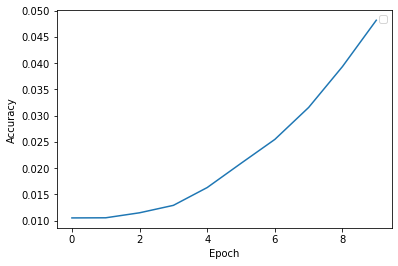

In [22]:
# Plot the Accuracy 
plt.plot(training_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()